In [1]:
!pwd

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

/content


In [ ]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification
!unzip /content/ham1000-segmentation-and-classification.zip

In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-unl3m7rk
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-unl3m7rk
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=1a33b88b12a6ec72e0e4e3dfa18b624a2a3d338937f1d3a4c38a66b4702f7646
  Stored in directory: /tmp/pip-ephem-wheel-cache-pu_lepwb/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [4]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import Image

from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
from matplotlib.pyplot import imshow

In [5]:
def undersample(df, count, rs=42):
  result=[]
  df_group = df.groupby('dx')
  for x in df['dx'].unique():
    group = df_group.get_group(x)
    num = int(group['dx'].value_counts())
    if num >= count:
      s=group.sample(count, axis=0, random_state=rs)
    else:
      s=group.sample(frac=1, axis=0, random_state=rs)
    result.append(s)
  return pd.concat(result, axis=0).reset_index(drop=True)

def oversample(df, count, rs=42):
  lst = [df]
  for class_index, group in df.groupby('dx'):
      lst.append(group.sample(count-len(group), replace=True, random_state=rs))
  df_new = pd.concat(lst)
  return df_new

def img_np_convert(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: np.asarray(Image.open(x).resize((h, w))).astype(np.float32))
  return df

def img_np_convert_scaled(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: (np.asarray(Image.open(x).resize((h, w)))/255).astype(np.float32))
  return df

def my_split(df, train_size, test_size, val_size, rs=42):
  valid_test_split = val_size / test_size

  df_train, df_test_val = train_test_split(df, test_size=1-train_size, shuffle=True, random_state=rs)
  df_val, df_test = train_test_split(df_test_val, test_size=valid_test_split, shuffle=True, random_state=rs)

  df_train.reset_index(inplace=True)
  return df_train, df_test, df_val

def weight_cal(df):
  class_weight={}
  labels = list(df['dx'].unique())
  labels.sort()
  count = df['dx'].value_counts()
  for idx in range(7):
    class_weight[idx] = count['nv']/count[labels[idx]]
  return class_weight, labels

def df_to_np1(df):
  image = np.asarray(df['image'].to_list()) 
  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return image, target

def df_to_np2(df):
  df['image'] = df['image'].map(lambda x : x.flatten())
  i_feature = np.asarray(df['image'].tolist())
  df_feature = df.iloc[:, 3:-1]
  c_feature = df_feature.loc[:, ~df_feature.columns.isin(['sex', 'dx'])].to_numpy()
  features = np.concatenate((i_feature, c_feature), axis=1)
  
  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return features, target

def image_augment(df, target, count, size, rs=42):
  df_group = df.groupby('dx')
  group = df_group.get_group(target)
  s=group.sample(count, axis=0, random_state=rs)

  datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode='nearest')
  
  for index, row in s.iterrows():
    image = row['image'].reshape((1, ) + row['image'].shape)
    gen = datagen.flow(image, batch_size=size)
    input = row.to_list()
    for i in range(size):
      img = next(gen)
      input[-1] = img[0]
      df.loc[len(df.index)] = input
  return None

In [6]:
def prep_pipeline2(upper_size, h, w, aug_targets, aug_count, aug_size, rs=42):
  df_o = pd.read_csv('../content/drive/MyDrive/DSE_I2100/data/HAM10000_metadata.csv')
  df_o = pd.get_dummies(data=df_o, columns=['dx_type', 'localization'])
  image_path = r'../content/images/'
  df_u = undersample(df_o, upper_size)
  df_u['age'].fillna(value=int(df_u['age'].mean()), inplace=True)
  df_u['age'] = df_u['age'].astype(np.float32)

  df = img_np_convert_scaled(df_u, image_path, h, w)

  df_train, df_test, df_val = my_split(df, 0.7, 0.2, 0.1, rs)

  for target in aug_targets:
    image_augment(df_train, target, aug_count, aug_size, rs)

  weight, labels = weight_cal(df_train)

  X_train, y_train = df_to_np2(df_train)
  X_test, y_test = df_to_np2(df_test)
  X_val, y_val = df_to_np2(df_val)
  return (X_train, y_train), (X_test, y_test), (X_val, y_val), weight, labels

In [7]:
h = 90
w = 90
aug_targets = ['mel', 'bcc']
aug_count = 50
aug_size = 4
majority = 6000

train_set, test_set, val_set, class_weight, labels = prep_pipeline2(majority, h, w, aug_targets, aug_count, aug_size)

In [8]:
X_train = train_set[0]
y_train = np.argmax(train_set[1], axis=1)

X_val = val_set[0]
y_val = np.argmax(val_set[1], axis=1)

X_test = test_set[0]
y_test = np.argmax(test_set[1], axis=1)

In [9]:
print(X_train.shape, X_test.shape, X_val.shape)

(6916, 24320) (1397, 24320) (1397, 24320)


In [10]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)
y_val = to_categorical(y_val, num_classes = 7)

In [11]:
class_weight

{0: 18.57079646017699,
 1: 7.441489361702128,
 2: 5.529644268774703,
 3: 50.566265060240966,
 4: 4.260913705583756,
 5: 1.0,
 6: 41.14705882352941}

In [29]:
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto')      
  ]

In [13]:
histories = {}

In [35]:
dnn_model = tf.keras.Sequential([                                                               
   keras.layers.Dense(64,
                      kernel_initializer = 'uniform',
                      input_dim=24320, 
                      activation = 'relu'),

   keras.layers.Dense(64, 
                      kernel_initializer = 'uniform',
                      activation = 'relu'),
   keras.layers.Dense(64, 
                      kernel_initializer = 'uniform',
                      activation = 'relu'),
   keras.layers.Dense(64, 
                      kernel_initializer = 'uniform',
                      activation = 'relu', 
                      kernel_regularizer=regularizers.l2(0.001)),
   keras.layers.Dropout(rate=.40, seed=42),

   keras.layers.Dense(7, activation='softmax')                                 
])

In [43]:
base_learning_rate = 0.0001
dnn_model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_learning_rate, epsilon = 1e-8), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [44]:
dnn_hist = dnn_model.fit(X_train, y_train, epochs=100, 
                         validation_data=(X_val, y_val), 
                         callbacks=get_callbacks(), 
                         )

Epoch 1/100
217/217 [==============================] - 2s 6ms/step - loss: 1.0825 - accuracy: 0.6274 - val_loss: 0.9105 - val_accuracy: 0.6850 - lr: 1.0000e-04
Epoch 2/100
217/217 [==============================] - 1s 4ms/step - loss: 1.0307 - accuracy: 0.6343 - val_loss: 0.9004 - val_accuracy: 0.6879 - lr: 1.0000e-04
Epoch 3/100
217/217 [==============================] - 1s 4ms/step - loss: 1.0037 - accuracy: 0.6404 - val_loss: 0.8893 - val_accuracy: 0.6865 - lr: 1.0000e-04
Epoch 4/100
217/217 [==============================] - 1s 4ms/step - loss: 1.0054 - accuracy: 0.6418 - val_loss: 0.8800 - val_accuracy: 0.6858 - lr: 1.0000e-04
Epoch 5/100
217/217 [==============================] - 1s 4ms/step - loss: 0.9824 - accuracy: 0.6511 - val_loss: 0.8857 - val_accuracy: 0.6893 - lr: 1.0000e-04
Epoch 6/100
217/217 [==============================] - 1s 4ms/step - loss: 0.9825 - accuracy: 0.6416 - val_loss: 0.8825 - val_accuracy: 0.6872 - lr: 1.0000e-04
Epoch 7/100
217/217 [===================

In [45]:
histories['dnn'] = dnn_hist

(0.0, 1.0)

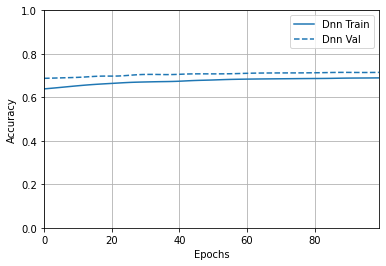

In [46]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)
plt.ylim([0, 1])

(0.0, 2.0)

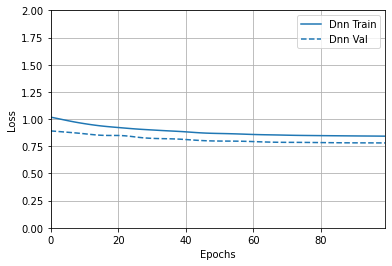

In [51]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)
plt.ylim([0, 2])

In [48]:
pred=dnn_model.predict(X_test)

In [49]:
y_pred=[]
for p in pred:
  pred_index=np.argmax(p)
  y_pred.append(pred_index)

In [50]:
y_ture=[]
for p in y_test:
  pred_index=np.argmax(p)
  y_ture.append(pred_index)

In [52]:
y_true = np.array(y_ture)
y_pred = np.array(y_pred)

In [53]:
cm = confusion_matrix(y_true, y_pred)

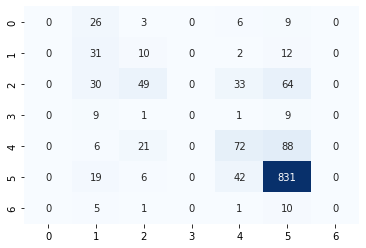

In [54]:
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)

In [55]:
clr = classification_report(y_true, y_pred, target_names=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
print(clr)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        44
         bcc       0.25      0.56      0.34        55
         bkl       0.54      0.28      0.37       176
          df       0.00      0.00      0.00        20
         mel       0.46      0.39      0.42       187
          nv       0.81      0.93      0.87       898
        vasc       0.00      0.00      0.00        17

    accuracy                           0.70      1397
   macro avg       0.29      0.31      0.28      1397
weighted avg       0.66      0.70      0.67      1397



In [57]:
dnn_model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 3ms/step - loss: 0.8223 - accuracy: 0.7037


[0.8223108649253845, 0.7036506533622742]